# Tutorial 7: Assembling custom pipelines

In [1]:
import homelette as hm

import matplotlib as plt
import seaborn as sns

## Introduction

Welcome to the final tutorial on `homelette`. This tutorial is about combining what we learnt in the previous tutorials about model generating and model evaluating building blocks.

The strength of `homelette` lies in its ability to *A)* be almost freely extendable by the user (see **Tutorial 4**) and *B)* in the ease with which pre-defined or custom-made building blocks for model generation and evaluation can be assembled into custom pipelines. This tutorial showcases *B)*.

We will build models for ARAF with two different routines, `Routine_automodel_default` and `Routine_automodel_slow` [1,2], and from different templates (BRAF ([3NY5](https://www.rcsb.org/structure/3NY5)) and RAF1 ([4G0N](https://www.rcsb.org/structure/4G0N))). The generated models will be evaluated by SOAP scores and MolProbity and a combined score will be calculated using Borda Count [3,4,5,6]. 

## Alignment

Consistent with the other tutorials, we will be modelling the protein ARAF. For this tutorial, we have prepared a more extensive alignment with two template structures, *3NY5* and *4G0N*.

In [2]:
# import alignment
aln = hm.Alignment('data/single/aln_2.fasta_aln')
aln.select_sequences(('ARAF', '3NY5', '4G0N')) #TODO DELETE
aln.print_clustal(line_wrap=70)

ARAF        ---GTVKVYLPNKQRTVVTVRDGMSVYDSLDKALKVRGLNQDCCVVYRLI---KGRKTVTAWDTAIAPLD
3NY5        HQKPIVRVFLPNKQRTVVPARCGVTVRDSLKKAL--RGLIPECCAVYRIQ------KKPIGWDTDISWLT
4G0N        -TSNTIRVFLPNKQRTVVNVRNGMSLHDCLMKALKVRGLQPECCAVFRLLHEHKGKKARLDWNTDAASLI


ARAF        GEELIVEVL------
3NY5        GEELHVEVLENVPLT
4G0N        GEELQVDFL------




In [3]:
# calculate sequence identity
aln.calc_identity_target('ARAF').sort_values(by='identity', ascending=False)

,sequence_1,sequence_2,identity
0,ARAF,ARAF,100.00
2,ARAF,4G0N,60.27
1,ARAF,3NY5,57.53


In [4]:
# annotate alignment
aln.get_sequence('ARAF').annotate(seq_type = 'sequence')
aln.get_sequence('3NY5').annotate(seq_type = 'structure',
                              pdb_code = '3NY5',
                              begin_res = '1',
                              begin_chain = 'A',
                              end_res = '77', 
                              end_chain = 'A')
aln.get_sequence('4G0N').annotate(seq_type = 'structure',
                              pdb_code = '4G0N',
                              begin_res = '1',
                              begin_chain = 'A',
                              end_res = '78', 
                              end_chain = 'A')

## Custom pipeline

The easiest way to formulate custom pipelines by assembling the `homelette` building blocks of model building and evaluation is to construct custom `Task` objects:

In [5]:
class CustomPipeline(hm.Task):
    '''
    Example for a cumstom pipeline
    '''
    def model_generation(self, templates):
        # model generation with automodel_default
        self.execute_routine(tag='automodel_def_' + '-'.join(templates),
                             routine = hm.routines.Routine_automodel_default,
                             templates = templates,
                             template_location = './data/complex/',
                             n_models = 20,
                             n_threads = 5)
        # model generation with autmodel_slow
        self.execute_routine(tag='autmodel_slow_' + '-'.join(templates),
                             routine = hm.routines.Routine_automodel_slow,
                             templates = templates,
                             template_location = './data/complex/',
                             n_models = 20,
                             n_threads = 5)
        
    def model_evaluation(self):
        # perform evaluation
        self.evaluate_models(hm.evaluation.Evaluation_mol_probity,
                             n_threads=5)
        self.evaluate_models(hm.evaluation.Evaluation_soap_protein)
        ev = self.get_evaluation()
        # borda count for best models
        ev['points_soap'] = ev.shape[0] - ev['soap_protein'].rank()
        ev['points_mol_probity'] = ev.shape[0] - ev['mp_score'].rank()
        ev['borda_score'] = ev['points_soap'] + ev['points_mol_probity']
        ev['borda_rank'] = ev['borda_score'].rank(ascending=False)
        ev = ev.drop(labels=['points_soap', 'points_mol_probity'], axis=1)
        return ev

We have constructed a custom `Task` object (more specifically, a custom objects that inherits all methods and attributes from `Task`) and added two more functions: `model_generation` and `model_evaluation`.

In `CustomPipeline.model_generation` we are using two routines (`Routine_automodel_default` and `Routine_automodel_slow`) to generate 20 models each. In `CustomPipeline.model_generation` we evaluate the models using `Evaluation_mol_probity` and `Evaluation_soap_protein` and then rank the generated models based on both evaluation metrics using Borda Count.

After constructing our pipeline, let's execute it with two different templates as an example:

In [6]:
# execute pipeline for different templates
t = CustomPipeline(task_name = 'Tutorial7',
                   target = 'ARAF',
                   alignment = aln,
                   overwrite = True)

t.model_generation(['3NY5'])
t.model_generation(['4G0N'])

df_eval = t.model_evaluation()

We have successfully generated and evaluated 80 models.

In [7]:
# get template from tag
df_eval['template'] = df_eval['tag'].str.contains('3NY5').map({True: '3NY5', False: '4G0N'})

In [8]:
df_eval.sort_values(by = 'borda_rank').head(10)

,model,tag,routine,mp_score,soap_protein,borda_score,borda_rank,template
64,autmodel_slow_4G0N_5.pdb,autmodel_slow_4G0N,automodel_slow,2.21,-45545.746094,148.0,1.0,4G0N
28,autmodel_slow_3NY5_9.pdb,autmodel_slow_3NY5,automodel_slow,2.31,-45972.250000,145.0,2.0,3NY5
77,autmodel_slow_4G0N_18.pdb,autmodel_slow_4G0N,automodel_slow,2.17,-45043.023438,144.0,3.0,4G0N
24,autmodel_slow_3NY5_5.pdb,autmodel_slow_3NY5,automodel_slow,2.42,-46180.289062,138.0,4.0,3NY5
69,autmodel_slow_4G0N_10.pdb,autmodel_slow_4G0N,automodel_slow,2.29,-45205.257812,137.0,5.0,4G0N
63,autmodel_slow_4G0N_4.pdb,autmodel_slow_4G0N,automodel_slow,2.26,-44921.707031,134.0,6.0,4G0N
22,autmodel_slow_3NY5_3.pdb,autmodel_slow_3NY5,automodel_slow,2.49,-48465.539062,132.5,7.0,3NY5
72,autmodel_slow_4G0N_13.pdb,autmodel_slow_4G0N,automodel_slow,2.20,-44206.707031,131.0,8.0,4G0N
79,autmodel_slow_4G0N_20.pdb,autmodel_slow_4G0N,automodel_slow,2.24,-44585.621094,130.5,9.0,4G0N
33,autmodel_slow_3NY5_14.pdb,autmodel_slow_3NY5,automodel_slow,2.50,-45825.039062,125.5,10.0,3NY5


We can see that most of the best 10 models were generated with the slower routine `Routine_autmodel_slow`. This is to be expected, as this routine spends more time on model refinement and should therefore produce "better" models.

Next, we visualize the results of our evaluation with `seaborn`.

## Visualization

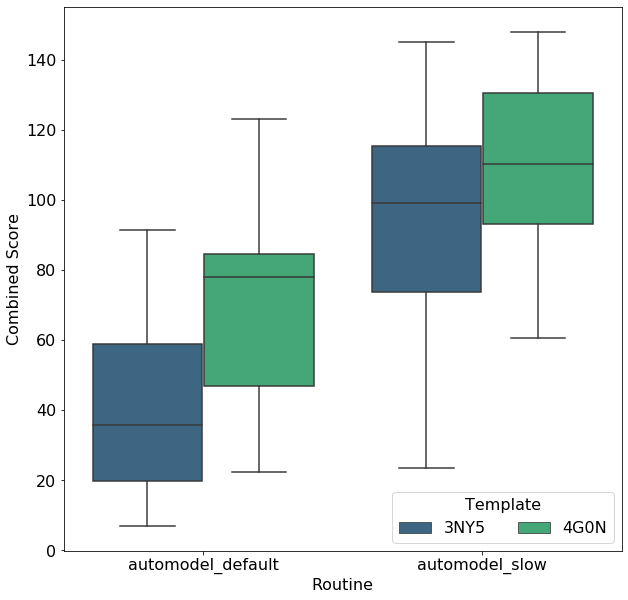

In [9]:
# visualize combined score with seaborn
%matplotlib inline

# set font size
plt.rcParams.update({'font.size': 16})

plot = sns.boxplot(x = 'routine', y = 'borda_score', hue='template', data=df_eval,
                   palette='viridis')
plot.set(xlabel = 'Routine')
plot.set(ylabel = 'Combined Score')
plot.figure.set_size_inches(10, 10)
plot.legend(title = 'Template', loc = 'lower right', ncol = 2, fancybox = True)
#plot.figure.savefig('tutorial7.png', dpi=300)

As expected, the routine which spends more time on model refinement (`Routine_automodel_slow`) produces on average better results. Also, there are interesting differences between the templates used.

## Further Reading

Congratulations on finishing the final tutorial about `homelette`. You might also be interested in the other tutorials:

- **Tutorial 1**: Learn about the basics of `homelette`.
- **Tutorial 2**: Learn more about already implemented routines for homology modelling.
- **Tutorial 3**: Learn about the evaluation metrics available with `homelette`.
- **Tutorial 4**: Learn about extending `homelette`'s functionality by defining your own modelling routines and evaluation metrics.
- **Tutorial 5**: Learn about how to use parallelization in order to generate and evaluate models more efficiently.
- **Tutorial 6**: Learn about modelling protein complexes.

## References

[1] Šali, A., & Blundell, T. L. (1993). Comparative protein modelling by satisfaction of spatial restraints. Journal of Molecular Biology, 234(3), 779–815. https://doi.org/10.1006/jmbi.1993.1626

[2] Webb, B., & Sali, A. (2016). Comparative Protein Structure Modeling Using MODELLER. Current Protocols in Bioinformatics, 54(1), 5.6.1-5.6.37. https://doi.org/10.1002/cpbi.3

[3] Dong, G. Q., Fan, H., Schneidman-Duhovny, D., Webb, B., Sali, A., & Tramontano, A. (2013). Optimized atomic statistical potentials: Assessment of protein interfaces and loops. Bioinformatics, 29(24), 3158–3166. https://doi.org/10.1093/bioinformatics/btt560

[4] Davis, I. W., Leaver-Fay, A., Chen, V. B., Block, J. N., Kapral, G. J., Wang, X., Murray, L. W., Arendall, W. B., Snoeyink, J., Richardson, J. S., & Richardson, D. C. (2007). MolProbity: all-atom contacts and structure validation for proteins and nucleic acids. Nucleic Acids Research, 35(suppl_2), W375–W383. https://doi.org/10.1093/NAR/GKM216

[5] Chen, V. B., Arendall, W. B., Headd, J. J., Keedy, D. A., Immormino, R. M., Kapral, G. J., Murray, L. W., Richardson, J. S., & Richardson, D. C. (2010). MolProbity: All-atom structure validation for macromolecular crystallography. Acta Crystallographica Section D: Biological Crystallography, 66(1), 12–21. https://doi.org/10.1107/S0907444909042073

[6] Williams, C. J., Headd, J. J., Moriarty, N. W., Prisant, M. G., Videau, L. L., Deis, L. N., Verma, V., Keedy, D. A., Hintze, B. J., Chen, V. B., Jain, S., Lewis, S. M., Arendall, W. B., Snoeyink, J., Adams, P. D., Lovell, S. C., Richardson, J. S., & Richardson, D. C. (2018). MolProbity: More and better reference data for improved all-atom structure validation. Protein Science, 27(1), 293–315. https://doi.org/10.1002/pro.3330


## Session Info

In [10]:
# session info
import session_info
session_info.show(html = False, dependencies = True)

-----
homelette           1.0
matplotlib          3.1.2
pandas              0.25.3
seaborn             0.11.2
session_info        1.0.0
-----
PIL                         7.0.0
altmod                      NA
anyio                       NA
attr                        19.3.0
babel                       2.9.1
backcall                    0.2.0
certifi                     2021.05.30
chardet                     3.0.4
charset_normalizer          2.0.4
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.7.3
debugpy                     1.4.1
decorator                   4.4.2
entrypoints                 0.3
idna                        3.2
ipykernel                   6.3.1
ipython_genutils            0.2.0
jedi                        0.18.0
jinja2                      3.0.1
json5                       NA
jsonschema                  3.2.0
jupyter_server              1.10.2
jupyterlab_server           2.8.0
kiwisolver                  1.0.1
markupsafe     